In [1]:
import CO2_Dataset_Preparation
import ML_Model_Master
import Result_Retriever

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *
from datetime import datetime
import pickle
import matplotlib.dates as mdates
from matplotlib import gridspec


import importlib
importlib.reload(CO2_Dataset_Preparation)
importlib.reload(ML_Model_Master)
importlib.reload(Result_Retriever)

from CO2_Dataset_Preparation import *
from ML_Model_Master import *
from Result_Retriever import *


Using TensorFlow backend.


In [5]:
#### Set Data Parameters and Retrieve From Folder ####

#Are you accessing the direct data or github downsampled test data? 
data_source = 'direct' #'git'

tower = 'Picarro'
pn = 4  #position number
excess_rolls = [60,600,3600] #define rolling window for excess calculation
downsample_sec = 60
periods_to_lag = 6
train_percent = 0.7

if data_source == 'direct':
    data = Processed_Set(tower,pn,excess_rolls,vent_bool = True, wbb_bool=False) #setup object 
    data._retrieve_data('../CO2_Data_Processed/') # get the data
    data._apply_excess() #add excess as columns 

    # Get the ML data
    ml_data = ML_Data(downsample_sec,periods_to_lag,tower,train_percent)
    ml_data._ML_Process(data) 
elif data_source == 'git':
    file_name =f'ml_data_pn{pn}_ds{downsample_sec}.pkl'
    with open(file_name, 'rb') as file:
        ml_data = pickle.load(file)
    

Applying excess using minimum on windows: [60, 600, 3600]
Downsampling by mean at 60 seconds
Downsampling by mean at 60 seconds
Adding Wind Direction for ANEM_X,ANEM_Y as 'wd'
Adding Wind Speed for ANEM_X,ANEM_Y as 'ws'


In [21]:
glob.glob("ml.pkl")

[]

In [6]:
file_name = f'ml_data_pn{pn}_ds{downsample_sec}.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(ml_data, file)

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


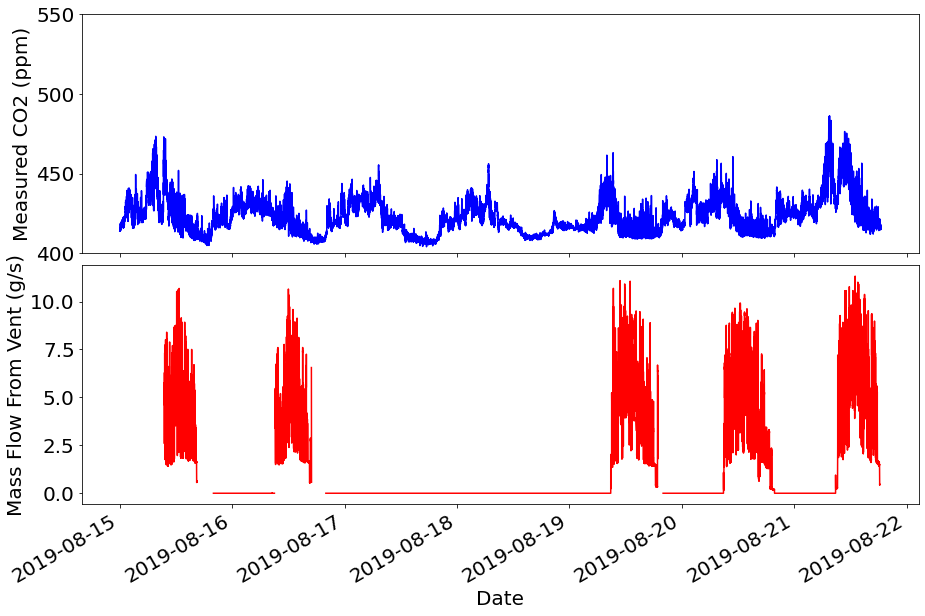

In [74]:
labsize = 20
df = ml_data.df_preprocessed

fig = plt.figure(figsize=(15,10))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
gs.update(hspace=0.05)


ax0 = fig.add_subplot(gs[0])
ax0.plot(df.index,df['Pic_CO2'],color='b',linestyle='-')
ax0.tick_params(axis='both', which='major', labelsize=labsize)
ax0.set_ylabel('Measured CO2 (ppm)',size=labsize)
ax0.yaxis.set_ticks(np.arange(400, 600, 50))

ax2 = fig.add_subplot(gs[1],sharex=ax0)
ax2.plot(df.index,df['m_dot'],'r')

ax2.tick_params(axis='both', which='major', labelsize=labsize)

ax2.set_ylabel('Mass Flow From Vent (g/s)',size=labsize)
ax2.set_xlabel('Date',size=labsize)

plt.gcf().autofmt_xdate()

    
fig.tight_layout()

In [90]:
#Setup plottable dfs
df = ml_data.df_preprocessed.copy()
dateidx = df.dropna().index
cols = df.columns
values = df.dropna().values
min_max_scalar = preprocessing.MinMaxScaler()
values_scaled = min_max_scalar.fit_transform(values)

scaled_df = pd.DataFrame(values_scaled)
scaled_df.set_index(dateidx,inplace = True)
scaled_df.columns = cols
scaled_df.reset_index(inplace=True)

length = len(scaled_df)
train_size = length*train_percent
train = scaled_df.loc[:train_size,:]
test = scaled_df.loc[train_size:,:]

train.set_index('Corrected_DT',inplace=True)
test.set_index('Corrected_DT',inplace=True)
train = train.resample('10s').mean()
test = test.resample('10s').mean()

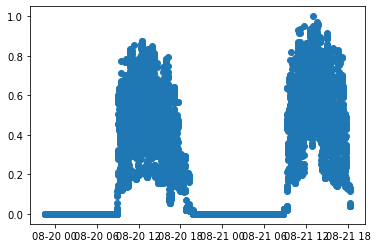

In [76]:
plt.scatter(test.index,test['m_dot'])

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


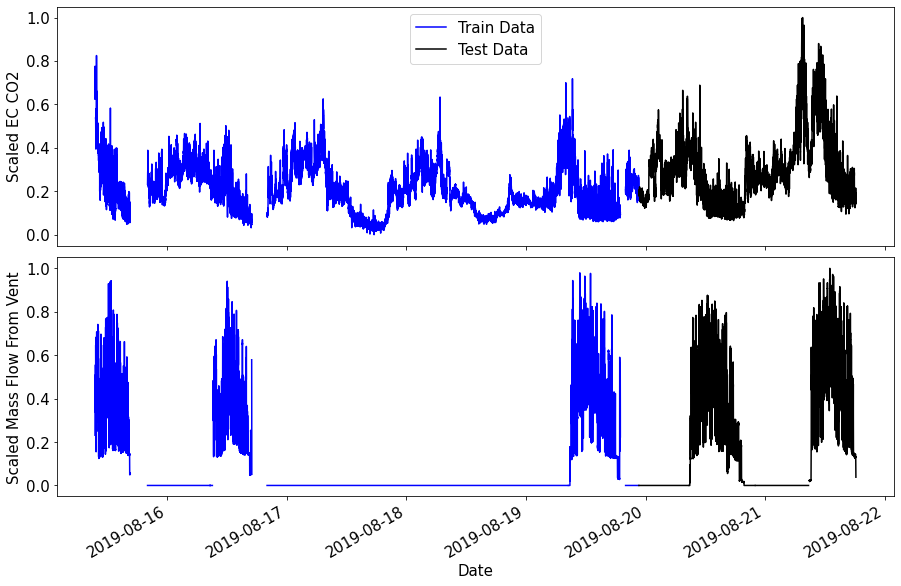

In [91]:

labsize = 15
fig = plt.figure(figsize=(15,10))

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1]) 
gs.update(hspace=0.05)


ax0 = fig.add_subplot(gs[0])

ax0.plot(train.index,train['Pic_CO2'],color='b', label = 'Train Data')
ax0.plot(test.index,test['Pic_CO2'],color='black',label='Test Data')
ax0.tick_params(axis='both', which='major', labelsize=labsize)
ax0.set_ylabel('Scaled EC CO2',size=labsize)


ax2 = fig.add_subplot(gs[1],sharex=ax0)
ax2.plot(train.index,train['m_dot'],'b')
ax2.plot(test.index,test['m_dot'],'black')

ax2.tick_params(axis='both', which='major', labelsize=labsize)

ax2.set_ylabel('Scaled Mass Flow From Vent',size=labsize)
ax2.set_xlabel('Date',size=labsize)

ax0.legend(fontsize=labsize)

plt.gcf().autofmt_xdate()

    
fig.tight_layout()

In [77]:
#Model Parameters
activation = 'relu'
neurons = 256
dropout_rate = 0.2
learn_rate = 0.001
decay = 1e-5
batch_size = 20
epochs = 100
error_metric = 'rmse'
logfile = None

ml_model = ML_Model_Builder(activation,neurons,dropout_rate,learn_rate,decay,batch_size,epochs)
ml_model._train_model(ml_data)

Downsampling = 10
Lag Periods = 6        
activation=relu
neurons=256
dropout_rate=0.2        
learn_rate=0.001
decay=1e-05
batch size=20
epochs=100
Train on 36286 samples, validate on 15552 samples
Epoch 1/100
36286/36286 [==============================] - 64s 2ms/step - loss: 0.0211 - rmse: 0.0824 - val_loss: 0.0514 - val_rmse: 0.1325
Epoch 2/100
36286/36286 [==============================] - 60s 2ms/step - loss: 0.0150 - rmse: 0.0655 - val_loss: 0.0483 - val_rmse: 0.1256
Epoch 3/100
36286/36286 [==============================] - 60s 2ms/step - loss: 0.0138 - rmse: 0.0604 - val_loss: 0.0487 - val_rmse: 0.1233
Epoch 4/100
36286/36286 [==============================] - 61s 2ms/step - loss: 0.0131 - rmse: 0.0577 - val_loss: 0.0441 - val_rmse: 0.1202
Epoch 5/100
36286/36286 [==============================] - 66s 2ms/step - loss: 0.0125 - rmse: 0.0558 - val_loss: 0.0443 - val_rmse: 0.1205
Epoch 6/100
36286/36286 [==============================] - 60s 2ms/step - loss: 0.0123 - rmse: 0.0546

Epoch 58/100
36286/36286 [==============================] - 68s 2ms/step - loss: 0.0037 - rmse: 0.0248 - val_loss: 0.0493 - val_rmse: 0.1227
Epoch 59/100
36286/36286 [==============================] - 68s 2ms/step - loss: 0.0038 - rmse: 0.0249 - val_loss: 0.0465 - val_rmse: 0.1193
Epoch 60/100
36286/36286 [==============================] - 71s 2ms/step - loss: 0.0036 - rmse: 0.0242 - val_loss: 0.0472 - val_rmse: 0.1201
Epoch 61/100
36286/36286 [==============================] - 68s 2ms/step - loss: 0.0035 - rmse: 0.0241 - val_loss: 0.0473 - val_rmse: 0.1198
Epoch 62/100
36286/36286 [==============================] - 69s 2ms/step - loss: 0.0035 - rmse: 0.0238 - val_loss: 0.0458 - val_rmse: 0.1207
Epoch 63/100
36286/36286 [==============================] - 68s 2ms/step - loss: 0.0034 - rmse: 0.0236 - val_loss: 0.0462 - val_rmse: 0.1203
Epoch 64/100
36286/36286 [==============================] - 70s 2ms/step - loss: 0.0033 - rmse: 0.0232 - val_loss: 0.0465 - val_rmse: 0.1200
Epoch 65/100


In [87]:
file_name = 'pn1_trained.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(ml_model, file)

/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [9]:
file_name =f'pn1_trained.pkl'
with open(file_name, 'rb') as file:
    ml_model = pickle.load(file)

In [78]:
ml_model._fit_data(ml_data)
#Return to original data shape and scale
X_test_original_shape = ml_data.X_test.reshape(ml_data.orig_X_test_shape) #reshape from 3d time
y_test_original_shape = ml_data.y_test.reshape(ml_data.orig_y_test_shape)#reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = ml_data.y_fit.reshape(ml_data.orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(ml_data.min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

Fitting data from X_test


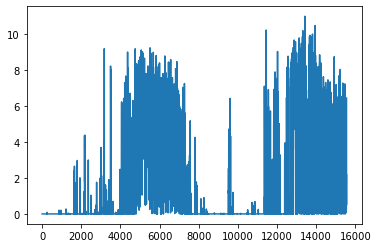

In [79]:
plt.plot(comparison['fit'])

In [80]:
df = ml_data.time_lagged_reframed.dropna().copy()
train = int(len(df)*train_percent)
df.reset_index(inplace = True)

dateidx = df.loc[train:,:].set_index('Corrected_DT').index
comparison.set_index(dateidx,inplace=True)

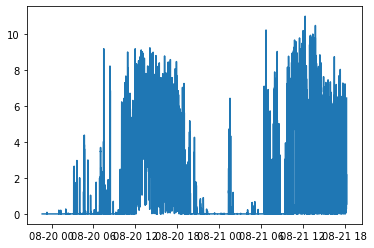

In [81]:
plt.plot(comparison['fit'])

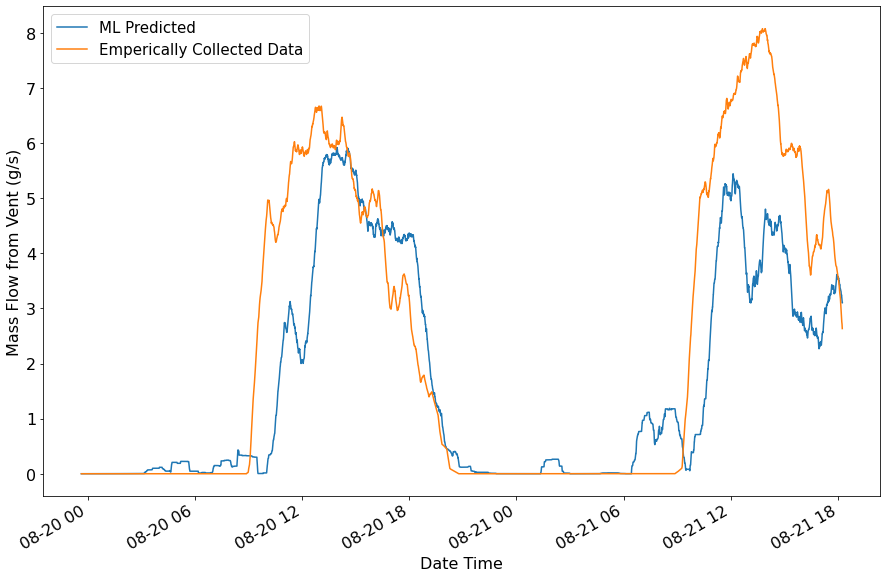

In [86]:
#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (15,10))

labsize = 15

roll = 360
ax.plot(comparison['fit'].rolling(roll).mean(),label='ML Predicted')
ax.plot(comparison['test'].rolling(roll).mean(),label='Emperically Collected Data')

ax.set_xlabel('Date Time',fontsize=16)
ax.set_ylabel('Mass Flow from Vent (g/s)',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)


ax.legend(fontsize=labsize,loc=2)


plt.gcf().autofmt_xdate()
plt.show()